In [ ]:
# Checking the GPU information

!nvidia-smi

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 27 18:13:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Install keras tuner
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 8.7 MB/s 


In [ ]:
# Importing required libraries

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
# Downloading the Chest X-ray dataset

!wget https://www.dropbox.com/s/73s9n7nugqrv1h7/Dataset.zip?dl=1 -O 'archive.zip'

--2022-03-27 18:14:06--  https://www.dropbox.com/s/73s9n7nugqrv1h7/Dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/73s9n7nugqrv1h7/Dataset.zip [following]
--2022-03-27 18:14:07--  https://www.dropbox.com/s/dl/73s9n7nugqrv1h7/Dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3a164147a90145595750d174fe.dl.dropboxusercontent.com/cd/0/get/BiSwB--IdKzkZ80UPHKBXd7TeVWRdxWfUw9emqUbG_52AaMhDxBhB8mzExjiJ5HEoFnMb5YOOqRgFBQPTbS4PVl5HDEWabxoe-pIrd_XFigZpqS8nnrZoPDxaJop5w5UEqvPT-wKNyRA07OuUTJLgh_BNaosbpP7Dul4IxxFfsP1PY3MRyPYchIG1zTMZ_x8ewE/file?dl=1# [following]
--2022-03-27 18:14:07--  https://uc3a164147a90145595750d174fe.dl.dropboxusercontent.com/cd/0/get/BiSwB--IdKzkZ80UPHKBXd7TeVWRdxWfUw9emqUbG_52AaMh

In [ ]:
# Unzipping the dataset and delete the .zip file

!unzip -q '/content/archive.zip'
#!rm -rf '/content/Dataset.zip'

In [ ]:
# Settting up random seed, and the dataset path

SEED = 21
dataset_path = '/content/Dataset'

In [ ]:
# Initialising ImageDataGenerator for data augmentation
# use random horizontal flip, width shift, heigh shift for augmentation
# Pixels will be notmalised between 0 and 1
# zca_epsilon: Epsilon for ZCA whitening. Default is 1e-6
# Rescale: Rescaling factor, defaults to None.
      

train_val_gen = ImageDataGenerator(zca_epsilon = 1e-06,
                                   horizontal_flip = True,
                                   rescale = 1./255,  
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,)        

test_gen = ImageDataGenerator(zca_epsilon = 1e-06,
                                   horizontal_flip = True,
                                   rescale = 1./255,  
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,)              



In [ ]:
# Taking input of the train, validation, and test images using flow_from_directory() function


def train_data_generation(data_gen,image_size,data_path):

  datagen = data_gen.flow_from_directory(directory = data_path,
                                                  target_size = (image_size, image_size),
                                                  color_mode = "rgb",
                                                  classes = None,
                                                  class_mode = "categorical",
                                                  batch_size = 64,
                                                  shuffle = True,
                                                  seed = SEED,
                                                  interpolation = "nearest")
  return datagen


# For testing, we should take one input at a time. Hence, batch_size = 1
def test_data_generation (img_size):
  test_datagen = test_gen.flow_from_directory(directory = dataset_path + '/test',
                                              target_size = (img_size, img_size),
                                              color_mode = "rgb",
                                              classes = None,
                                              class_mode = "categorical",
                                              batch_size = 1,
                                              shuffle = False,
                                              seed = SEED,
                                              interpolation = "nearest")
  return test_datagen

In [ ]:
#List of all available pretrained models
import inspect
from tqdm import tqdm
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping


# model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}
model_list = [m for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)]
# model_classes = (tf.keras.Model, keras.Model)
print(len(model_list))

35


In [ ]:
pretrained_model = keras.applications.VGG16(weights = 'imagenet',
                          classes = 1000,
                          input_shape = (224,224,3),
                          include_top = False,
                          pooling = 'max')
names = [layer.name for layer in pretrained_model.layers]
# print(names)
indexes = [(names.index(conv)-len(names)) for conv in names if "conv" in conv]
print(indexes)
print(indexes[-10:])

58900480/58889256 [==============================] - 0s 0us/step
[-19, -18, -16, -15, -13, -12, -11, -9, -8, -7, -5, -4, -3]
[-15, -13, -12, -11, -9, -8, -7, -5, -4, -3]


In [ ]:
from keras_tuner.protos.keras_tuner_pb2 import HyperParameters
# benchmarks dictionary to store the accuracy of the best configuration of each model
model_benchmarks = {'model_name':[], 'test_accuracy':[], 'test_loss':[]}
optimized_configs = {'model_name':[],'trainable_layer':[], 'optimizer':[], 'learning_rate':[], 'dense':[],'batch_size':[]}

#Loop all over available pretrained models in keras
for model_name, pre_model in model_list[32:33]:
# for model_name, pre_model in tqdm(model_dictionary.items()):
  if 'NASNetLarge' in model_name:
    input_shape = (331, 331, 3)
    train_datagen = train_data_generation(train_val_gen,331, dataset_path + '/train')
    val_datagen = train_data_generation(train_val_gen,331, dataset_path + '/val')
    test_datagen = test_data_generation (331)
  elif 'ception' in model_name:
    input_shape = (299, 299, 3)
    train_datagen = train_data_generation(train_val_gen,299, dataset_path + '/train')
    val_datagen = train_data_generation(train_val_gen,299, dataset_path + '/val')
    test_datagen = test_data_generation (299)
  else: 
    input_shape = (224, 224, 3)
    train_datagen = train_data_generation(train_val_gen,224, dataset_path + '/train')
    val_datagen = train_data_generation(train_val_gen,224, dataset_path + '/val')
    test_datagen = test_data_generation (224)

  #Load pretrained models
  print("----------------------------------------\n")
  print(model_name)
  pretrained_model = pre_model(weights = 'imagenet',
                          classes = 1000,
                          input_shape = input_shape,
                          include_top = False,
                          pooling = 'max')
  print("\n")
  # print(len(pretrained_model.layers))
  # print(isinstance(pretrained_model, model_classes))

  names = [layer.name for layer in pretrained_model.layers]
  # print(names)
  indexes = [(names.index(conv)-len(names)) for conv in names if "conv" in conv]
  print(indexes)

  #Defining a class of hyperparameter model
  class MyHyperModel(kt.HyperModel):
    def build(self, hp):

      # Defining a set of hyperparameters for tuning and their range of value
      # hp_activation = hp.Choice(name = 'activation', values = ['relu', 'sigmoid', 'tanh'], ordered = False)
      hp_trainable = hp.Choice('trainable_layer', values = indexes[-10:]+[0])
      hp_learning_rate = hp.Choice('learning_rate', values = [1e-2,1e-3,1e-4,1e-5])
      # hp_dropout_rate = hp.Choice('dropout', values=[0., 0.1, 0.25, 0.5])
      # hp_dropout = hp.Boolean("dropout")
      hp_units = hp.Int('dense', min_value = 32, max_value = 1024, step = 32)

      hp_optimizer = hp.Choice('optimizer', values=['sgd', 'rmsprop', 'adam'])
      if hp_optimizer == 'sgd':
          optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.95)
      elif hp_optimizer == 'rmsprop':
          optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate, momentum=0.95)
      elif hp_optimizer == 'adam':
          optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
      else:
        raise


      # Freeze the layers except the last hp_trainable layers
      # for layer in pretrained_model.layers[:hp_trainable]:
      if (hp_trainable !=0 ):
        for layer in pretrained_model.layers[:hp_trainable]:
            layer.trainable = False
      # else:
      #   # Check the trainable status of the individual layers
      #   for layer in pretrained_model.layers:
      #       print(layer, layer.trainable)


      # Create the model
      model = models.Sequential()
      
      # Add the pretranined base model
      model.add(pretrained_model)
      
      # Add new layers
      model.add(layers.Flatten())
      model.add(layers.Dense(units = hp_units, activation='relu'))
      #Tune whether to use dropout:
      # if hp_dropout:
      model.add(layers.Dropout(rate=0.5))
      model.add(layers.Dense(3, activation='softmax'))
      
      
      # Define optimizer with learning rate as hyperparameters
      # model.compile(optimizer = optimizer, 
      model.compile(optimizer = hp_optimizer, 
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
      return model

    # Defining batch size as a hyperparameter 
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice('batch_size', values = [32, 64, 128]),
            **kwargs,
        )
  

  # General variables for experiment
  # tuner_max_trials = 1
  # tuner_epochs = 5
  # best_train_epochs = 50

  tuner = kt.Hyperband(
    MyHyperModel(),
    objective='val_accuracy',
    overwrite=True, 
    max_epochs=10,
    factor=3,
    project_name= model_name)
  # tuner = kt.BayesianOptimization(
  #     build_hyper_model,
  #     objective='val_accuracy',
  #     max_trials=tuner_max_trials,
  #     seed = 21,
  #     project_name= model_name)
  

  # Initialize an early stopping callback to prevent the model from
  # overfitting/spending too much time training with minimal gains
  
  # early_stopping = EarlyStopping(
  #   monitor='val_accuracy',
  #   mode='max',
  #   patience=1,
  #   baseline=0.8,
  #   restore_best_weights=True)
  early_stopping = EarlyStopping(
  monitor='val_loss',
  patience=5)


  print("[INFO] performing hyperparameter search...")
  tuner.search(
    train_datagen,
    validation_data=val_datagen, 
    callbacks=[early_stopping],
    epochs=30,
  )


  # Grab the best hyperparameters
  print("[INFO] saving optimized model's configuration ...\n")

  bestHP = tuner.get_best_hyperparameters(num_trials=1)[0]
  
  # Store configuration into optimized configs dictionary

  optimized_configs['model_name'].append(model_name)
  optimized_configs['trainable_layer'].append(bestHP.get('trainable_layer'))
  optimized_configs['optimizer'].append(bestHP.get('optimizer'))
  optimized_configs['learning_rate'].append(bestHP.get('learning_rate'))
  optimized_configs['dense'].append(bestHP.get('dense'))
  optimized_configs['batch_size'].append(bestHP.get('batch_size'))
  
  # Check the best model from above trials
  best_model=tuner.get_best_models(num_models=1)[0]
  
  # ModelCheckpoint callback will save models weight if the training accuracy of the model has increased from the previous epoch
  model_filepath = '/content/best_VGG16-hyper.h5'
  model_save = tf.keras.callbacks.ModelCheckpoint(model_filepath,
                                                  monitor = "val_accuracy",
                                                  verbose = 0,
                                                  save_best_only = True,
                                                  save_weights_only = False,
                                                  mode = "max",
                                                  save_freq = "epoch")


  # Retrained optimized model

  fit_callback = [model_save]
  hp_history = best_model.fit(train_datagen, epochs=100, validation_data=(val_datagen), shuffle = False,callbacks = fit_callback)

  # Model prediction on test set

  results = best_model.evaluate(test_datagen,
                              verbose = 1,
                              steps = (len(test_datagen)))
  # Calculate relevant metrics to store to benchmarks dictionary
  model_benchmarks['model_name'].append(model_name)
  model_benchmarks['test_accuracy'].append(results[1])
  model_benchmarks['test_loss'].append(results[0])

Trial 30 Complete [00h 21m 04s]
val_accuracy: 0.9664074778556824

Best val_accuracy So Far: 0.9682736992835999
Total elapsed time: 06h 24m 41s
INFO:tensorflow:Oracle triggered exit
[INFO] saving optimized model's configuration ...

Epoch 1/100
177/177 [==============================] - 212s 1s/step - loss: 0.0276 - accuracy: 0.9902 - val_loss: 0.1936 - val_accuracy: 0.9667
Epoch 2/100
177/177 [==============================] - 210s 1s/step - loss: 0.0246 - accuracy: 0.9924 - val_loss: 0.2061 - val_accuracy: 0.9664
Epoch 3/100
177/177 [==============================] - 210s 1s/step - loss: 0.0211 - accuracy: 0.9922 - val_loss: 0.2173 - val_accuracy: 0.9630
Epoch 4/100
177/177 [==============================] - 211s 1s/step - loss: 0.0218 - accuracy: 0.9928 - val_loss: 0.2202 - val_accuracy: 0.9636
Epoch 5/100
177/177 [==============================] - 210s 1s/step - loss: 0.0191 - accuracy: 0.9944 - val_loss: 0.2080 - val_accuracy: 0.9661
Epoch 6/100
177/177 [===========================

In [ ]:
import pandas as pd

#Convert results to dataframe
benchmark_df = pd.DataFrame(model_benchmarks)
benchmark_df


,model_name,test_accuracy,test_loss
0,VGG16,0.96801,0.338551


In [ ]:
# Convert & show optimized models' configuration
optimized_conf_df = pd.DataFrame(optimized_configs)
optimized_conf_df

,model_name,trainable_layer,optimizer,learning_rate,dense,batch_size
0,VGG16,-7,sgd,0.001,320,128


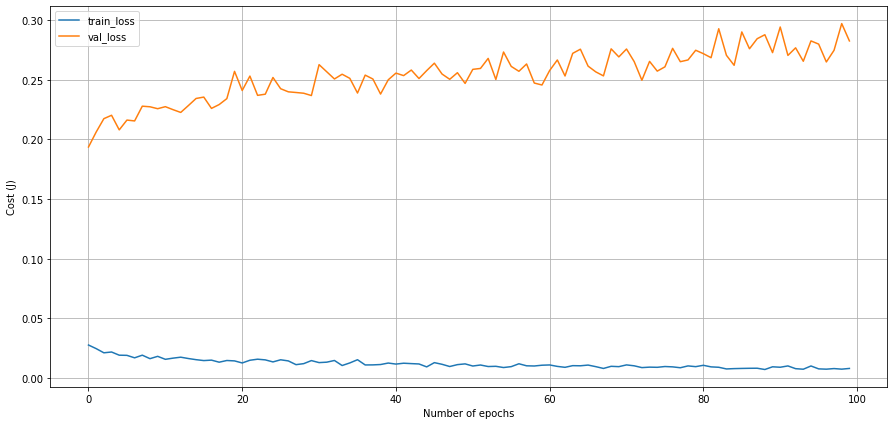

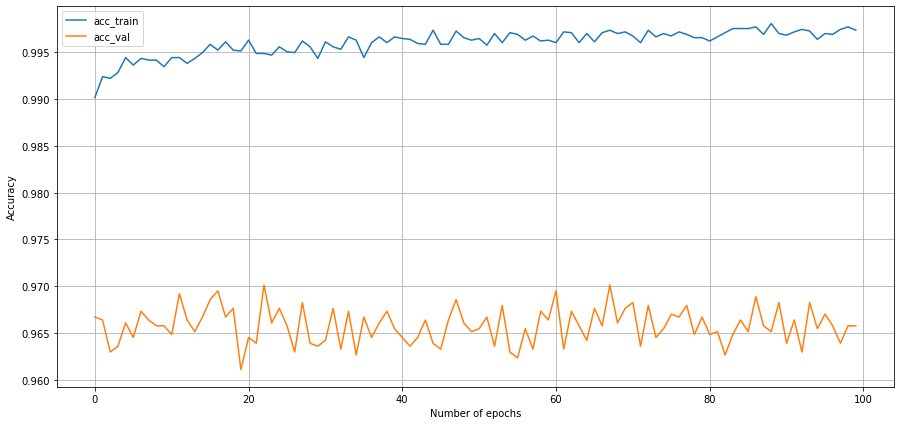

In [ ]:
# Plotting the loss and accuracy graphs

import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))

tr_losses = hp_history.history['loss']
val_losses = hp_history.history['val_loss']

tr_accs = hp_history.history['accuracy']
val_accs = hp_history.history['val_accuracy']

plt.plot(tr_losses, label = "train_loss")
plt.plot(val_losses, label = "val_loss")
plt.xlabel("Number of epochs")
plt.ylabel("Cost (J)")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize = (15,7))

plt.plot(tr_accs, label = "acc_train")
plt.plot(val_accs, label = "acc_val")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()

## Model evaluation on test set



In [ ]:
# Model prediction on test set

predictions =  best_model.predict(test_datagen,
                            verbose = 1,
                            steps = (len(test_datagen)))

1563/1563 [==============================] - 25s 16ms/step


In [ ]:
# Printing predicted classes on the test dataset

predictions.squeeze().argmax(axis = -1)

array([0, 0, 0, ..., 2, 2, 2])

In [ ]:
# Generating the classification report for checking the model's performance on the test set of the same dataset

classification__report = classification_report(test_datagen.classes,
                                               predictions.squeeze().argmax(axis = 1))
print(classification__report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       491
           1       0.95      0.98      0.96       545
           2       0.99      0.95      0.97       527

    accuracy                           0.97      1563
   macro avg       0.97      0.97      0.97      1563
weighted avg       0.97      0.97      0.97      1563



In [ ]:
# Generating confusion matrix to see where the model is misclassifying

confusion__matrix = confusion_matrix(test_datagen.classes,
                                     predictions.squeeze().argmax(axis = 1))
print(confusion__matrix)

[[479  10   2]
 [ 11 532   2]
 [  5  20 502]]


In [ ]:
# Defining a function to print a confusion matrix

import itertools
def plot_confusion_matrix(cm,
                          classes,
                          normalise = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Reds):
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalise:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = cm.round(2)

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

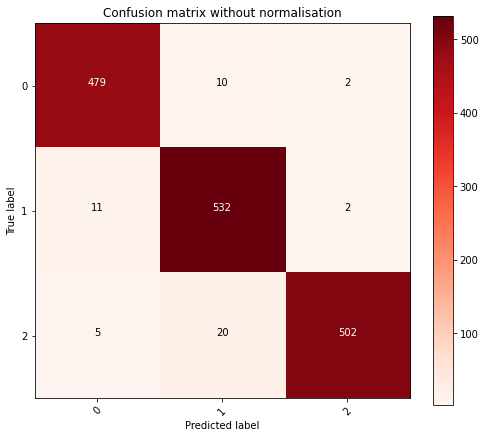

In [ ]:
# Printing the confusion matrix (not normalised)

np.set_printoptions(precision = 2)
fig1 = plt.figure(figsize = (7, 6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(test_datagen.classes),
                      title = 'Confusion matrix without normalisation')
fig1.savefig('/content/cm_wo_norm.jpg')
plt.show()

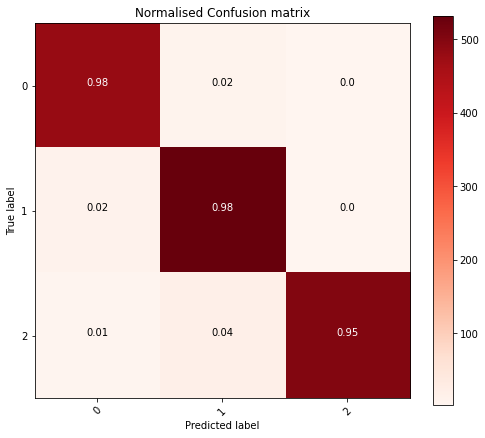

In [ ]:
# Printing the confusion matrix (normalised)

np.set_printoptions(precision = 2)
fig2 = plt.figure(figsize = (7,6))
plot_confusion_matrix(confusion__matrix,
                      classes = np.unique(test_datagen.classes),
                      normalise = True,
                      title = 'Normalised Confusion matrix')
fig2.savefig('/content/cm_norm.jpg')
plt.show()